cycle-by-cycle analysis of beta burst
Auditory Brainstorm dataset
using MNEtools & bycycle tool


In [ ]:

import os
import os.path as op
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
from scipy import stats

import mne
from mne import combine_evoked
from mne.minimum_norm import apply_inverse
from mne.datasets.brainstorm import bst_auditory
from mne.io import read_raw_ctf
import matplotlib.pyplot as plt
from bycycle.filt import lowpass_filter, bandpass_filter
from bycycle.cyclepoints import _fzerorise, _fzerofall, find_extrema, find_zerox
from bycycle.features import compute_features
from bycycle.burst import plot_burst_detect_params

Read data:
Data consits out of a noise recording of the room, and data from 1 participant, which completed 2 run. Each run consisted out of 200 regular beeps and 40 deviant beeps. Data was collected with a CTF 275 system at 2400Hz. 


In [ ]:
#%% prepare for reading data
#set working director
os.chdir('D:/school/2e master/case studies/2020CAED')#! be sure to change this to your working directory
#use precomputed steps
use_precomputed = True 

#get the data in directory/download if not in the directory 
data_path = bst_auditory.data_path('D:/school/2e master/case studies/mne_data')


subject = 'bst_auditory'
subjects_dir = op.join(data_path, 'subjects')

raw_fname1 = op.join(data_path, 'MEG', 'bst_auditory', ##data file of first run
                     'S01_AEF_20131218_01.ds')
raw_fname2 = op.join(data_path, 'MEG', 'bst_auditory', ##data file of scnd run
                     'S01_AEF_20131218_02.ds')
erm_fname = op.join(data_path, 'MEG', 'bst_auditory',  ##noise recording of room 
                    'S01_Noise_20131218_01.ds')
#read data
preload = not use_precomputed ##data stored in memory (needed for some functions)
raw = read_raw_ctf(raw_fname1, preload=preload) 
n_times_run1 = raw.n_times
mne.io.concatenate_raws([raw, read_raw_ctf(raw_fname2, preload=preload)])##make one continious data set out of first and second run
raw_erm = read_raw_ctf(erm_fname, preload=preload)

Define channels:
set EOG and ECG channel

In [ ]:
#define channels
raw.set_channel_types({'HEOG': 'eog', 'VEOG': 'eog', 'ECG': 'ecg'})
if not use_precomputed:
    # Leave out the two EEG channels for easier computation of forward.
    raw.pick(['meg', 'stim', 'misc', 'eog', 'ecg'])


Label bad segments:
Bad segments and sacades were idenified and stored in csv file. These segments are rejected during epoching. saccades and eye movements are removed by using SSP.

In [ ]:
#read bad segments from csv file 
annotations_df = pd.DataFrame()
offset = n_times_run1
for idx in [1, 2]:
    csv_fname = op.join(data_path, 'MEG', 'bst_auditory',
                        'events_bad_0%s.csv' % idx)
    df = pd.read_csv(csv_fname, header=None,
                     names=['onset', 'duration', 'id', 'label'])
    print('Events from run {0}:'.format(idx))
    print(df)

    df['onset'] += offset * (idx - 1)
    annotations_df = pd.concat([annotations_df, df], axis=0)

saccades_events = df[df['label'] == 'saccade'].values[:, :3].astype(int)

# Conversion from samples to time (s):
onsets = annotations_df['onset'].values / raw.info['sfreq']
durations = annotations_df['duration'].values / raw.info['sfreq']
descriptions = annotations_df['label'].values

annotations = mne.Annotations(onsets, durations, descriptions)
raw.set_annotations(annotations)
del onsets, durations, descriptions

#add EOG & saccade projectors
saccade_epochs = mne.Epochs(raw, saccades_events, 1, 0., 0.5, preload=True,
                            baseline=(None, None),
                            reject_by_annotation=False)

projs_saccade = mne.compute_proj_epochs(saccade_epochs, n_mag=1, n_eeg=0,
                                        desc_prefix='saccade')
if use_precomputed:
    proj_fname = op.join(data_path, 'MEG', 'bst_auditory',
                         'bst_auditory-eog-proj.fif')
    projs_eog = mne.read_proj(proj_fname)[0]
else:
    projs_eog, _ = mne.preprocessing.compute_proj_eog(raw.load_data(),
                                                      n_mag=1, n_eeg=0)
raw.add_proj(projs_saccade)
raw.add_proj(projs_eog)
del saccade_epochs, saccades_events, projs_eog, projs_saccade  # To save memory

Visual inspection:
inspect the data after projection. The annotations are added to the data. Bad channels can be marked as 'bad' by clicking them. 

In [ ]:
raw.plot(block = True)

Add events:
events are extracted from the stimulus channel. Event timing is adjusted by comparing the stimulus trigger & the onset on the auditory channel.

In [ ]:
#add events
events = mne.find_events(raw, stim_channel = "UPPT001")
event_dict = {'standard': 1, 'deviant': 2}
##adjust event timing:difference between auditory channel & stimulus channel 
sound_data = raw[raw.ch_names.index('UADC001-4408')][0][0]
onsets = np.where(np.abs(sound_data) >2. *np.std(sound_data))[0]
min_diff = int(0.5 *raw.info['sfreq'])
diffs = np.concatenate([[min_diff+1],np.diff(onsets)])
onsets = onsets[diffs> min_diff]
assert len(onsets) == len(events)
diffs = 1000. * (events[:, 0] - onsets) / raw.info['sfreq']
print('Trigger delay removed (μ ± σ): %0.1f ± %0.1f ms'
      % (np.mean(diffs), np.std(diffs)))
events[:, 0] = onsets
del sound_data, diffs
#remove noisy channels
raw.info['bads']= ['MLO52-4408','MRT51-4408','MLO42-4408','MLO43-4408']
##visual inspection of bad channels, mark as bad by clicking 
raw.plot(events, event_color = {1: 'b', 2: 'r'})


Epoch:
The continious data is epoched from 100ms prestimulus onset till onset of the stimulus.

In [ ]:
#epoch
tmin,tmax = -1, 0 #start & end of time window used to reject epoch 
reject = dict(mag=4e-12, eog=250e-6) #rejection parameters of peak to peak amplitude 
epochs = mne.Epochs(raw, events, event_dict, tmin, tmax, picks=['meg', 'eog'],
                    baseline=(None, 0), reject=reject, preload=False, ##epochs overlapping 'bad' segments removed 
                    proj=True)
epochs.drop_bad()
epochs_standard = mne.concatenate_epochs([epochs['standard'][range(40)], #only 40 good epochs from each run
                                          epochs['standard'][182:222]]) #first epoch from 2nd run corresponds to 182
epochs_standard.load_data()  # Resampling to save memory.
epochs_standard.resample(600, npad='auto')
epochs_deviant = epochs['deviant'].load_data()
epochs_deviant.resample(600, npad='auto')
del epochs
evoked_std = epochs_standard.average()
evoked_dev = epochs_deviant.average()


Pick channels:
Beta burst are mainly observed in frontal part of the brain. We are comparing frontal oscillatory activity with occipital. 

In [ ]:
#%%pick channels
Fc = [ 'MZF01-4408',
           'MZF02-4408',
           'MZF03-4408']
Fl = ['MLF11-4408',
         'MLF12-4408',
         'MLF13-4408',
         'MLF14-4408',
         'MLF21-4408',
         'MLF22-4408',
         'MLF23-4408',
         'MLF24-4408',
         'MLF25-4408',
         'MLF31-4408',
         'MLF32-4408',
         'MLF33-4408',
         'MLF34-4408',
         'MLF35-4408',
         'MLF41-4408',
         'MLF42-4408',
         'MLF43-4408',
         'MLF44-4408',
         'MLF45-4408',
         'MLF46-4408',
         'MLF51-4408',
         'MLF52-4408',
         'MLF53-4408',
         'MLF54-4408',
         'MLF55-4408',
         'MLF56-4408',
         'MLF61-4408',
         'MLF62-4408',
         'MLF63-4408',
         'MLF64-4408',
         'MLF65-4408',
         'MLF66-4408',
         'MLF67-4408'] 
Fr= [ 'MRF11-4408',
         'MRF12-4408',
         'MRF13-4408',
         'MRF14-4408',
         'MRF21-4408',
         'MRF22-4408',
         'MRF23-4408',
         'MRF24-4408',
         'MRF25-4408',
         'MRF31-4408',
         'MRF32-4408',
         'MRF33-4408',
         'MRF34-4408',
         'MRF35-4408',
         'MRF41-4408',
         'MRF42-4408',
         'MRF43-4408',
         'MRF44-4408',
         'MRF45-4408',
         'MRF46-4408',
         'MRF51-4408',
         'MRF52-4408',
         'MRF53-4408',
         'MRF54-4408',
         'MRF55-4408',
         'MRF56-4408',
         'MRF61-4408',
         'MRF62-4408',
         'MRF63-4408',
         'MRF64-4408',
         'MRF65-4408',
         'MRF66-4408',
         'MRF67-4408',]
frontal= Fc+Fl+Fr



Oc = [ 'MZO01-4408',
 'MZO02-4408',
 'MZO03-4408']
Ol = [ 'MLO11-4408',
 'MLO12-4408',
 'MLO13-4408',
 'MLO14-4408',
 'MLO21-4408',
 'MLO22-4408',
 'MLO23-4408',
 'MLO24-4408',
 'MLO31-4408',
 'MLO32-4408',
 'MLO33-4408',
 'MLO34-4408',
 'MLO41-4408',
 'MLO42-4408',
 'MLO43-4408',
 'MLO44-4408',
 'MLO51-4408',
 'MLO52-4408',
 'MLO53-4408']
Or =  ['MRO11-4408',     
 'MRO12-4408',
 'MRO13-4408',
 'MRO14-4408',
 'MRO21-4408',
 'MRO22-4408',
 'MRO23-4408',
 'MRO24-4408',
 'MRO31-4408',
 'MRO32-4408',
 'MRO33-4408',
 'MRO34-4408',
 'MRO41-4408',
 'MRO42-4408',
 'MRO43-4408',
 'MRO44-4408',
 'MRO51-4408',
 'MRO52-4408',
 'MRO53-4408']

occipital = Oc+Ol+Or


Start cycle by cyle analysis:
Signals are converted into 1-D numpy arrays and a 40Hz lowpass filter is applied.

In [ ]:
#%%start by cycle analysis
#preprocessing 
signal_frontal = []
for i in range(len(frontal)):
    signal = epochs_deviant.get_data(picks = frontal[i])#convert to numpy array 
    signal = signal[:,0,:]
    signal_frontal.append(np.ravel(signal))
del signal

signal_occipital = []
for i in range(len(occipital)):
    signal = epochs_deviant.get_data(picks = occipital[i])
    signal = signal[:,0,:]
    signal_occipital.append(np.ravel(signal))    
del signal

signals = [signal_frontal, signal_occipital]

Fs = 600
f_beta = (15, 30)
f_lowpass = 40
N_seconds = .1

#lowpass 
for i in range(len(signals)):
    for j in range(len(signals[i])):
        signals[i][j] = lowpass_filter(signals[i][j], Fs, f_lowpass,
                            N_seconds=N_seconds, remove_edge_artifacts=False)

Example of 3 signals in the frontal & occipital area

In [ ]:
#%%
# Plot signal
N = len(signals[0])

T = len(signals[0][0])/Fs
t = np.arange(0, T, 1/Fs)


fig, axs = plt.subplots(3,figsize=(15, 9))
fig.suptitle('Frontal sensors')
axs[0].plot(t, signals[0][0], 'k')
axs[1].plot(t,signals[0][1],'k')
axs[2].plot(t,signals[0][2],'k')
#plt.xlim((0, T))
#plt.show()
fig, axs = plt.subplots(3,figsize=(15, 9))
fig.suptitle('Occipital sensors')
axs[0].plot(t, signals[1][0], 'k')
axs[1].plot(t,signals[1][1],'k')
axs[2].plot(t,signals[1][2],'k')


Cycle feature computation:


In [14]:
burst_kwargs = {'amplitude_fraction_threshold': 0.2,
                'amplitude_consistency_threshold': .4,
                'period_consistency_threshold': .5,
                'monotonicity_threshold': .8,}

dfs = []
for i in range(len(signals)):
    for j in range(len(signals[i])):
        df = compute_features(signals[i][j], Fs, f_beta,
                          burst_detection_method='cycles',
                          burst_detection_kwargs=burst_kwargs)
        if i == 0:
            df['region'] = 'frontal'
            df['sensor'] = frontal[j]
        else:
            df['region'] = 'occipital'
            df['sensor'] = occipital[j]
        dfs.append(df)
df_cycles = pd.concat(dfs)

C:\Users\andre\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\andre\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Confirm appropriateness of burst detection parameters:
Example of burst detection for sensor 'MZf01' is plotted.

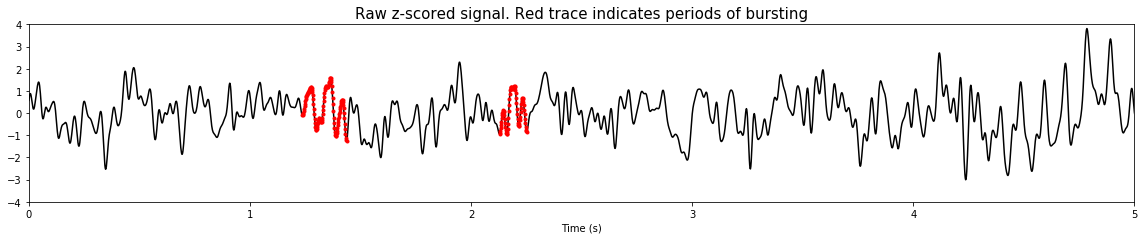

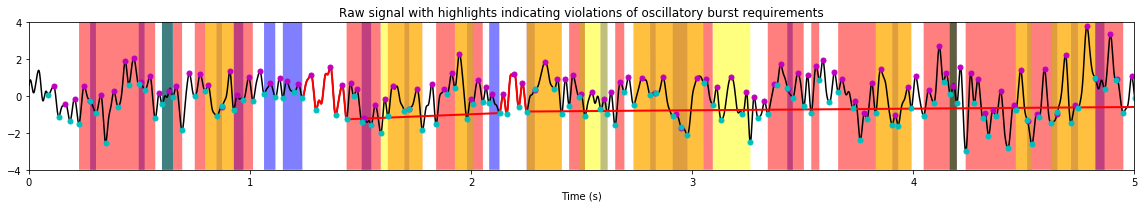

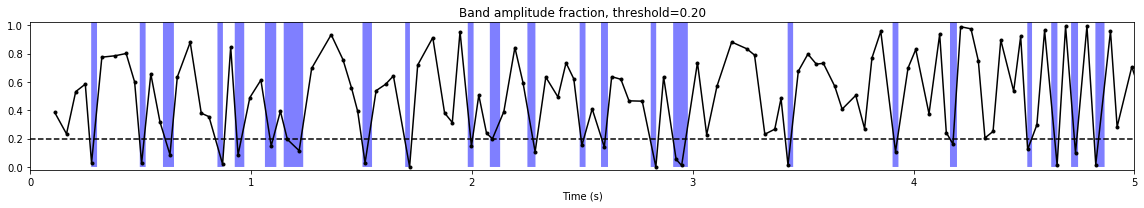

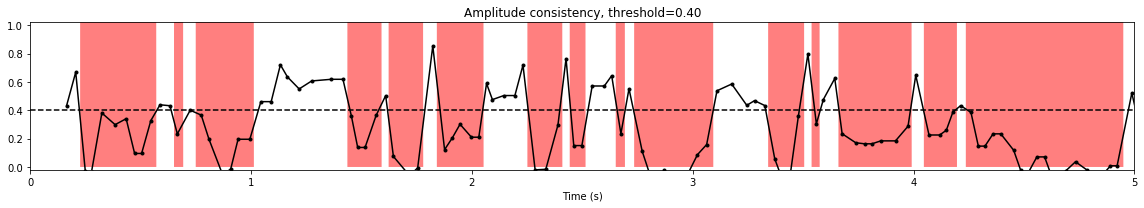

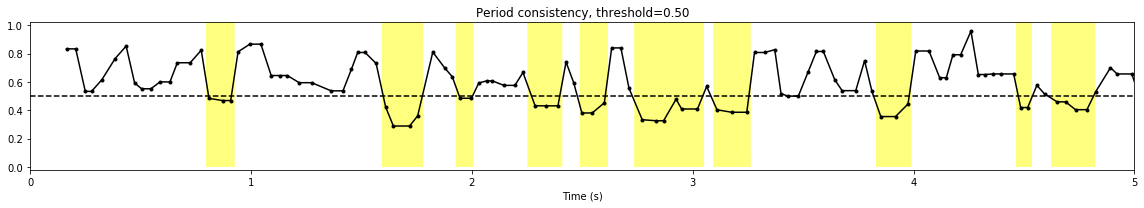

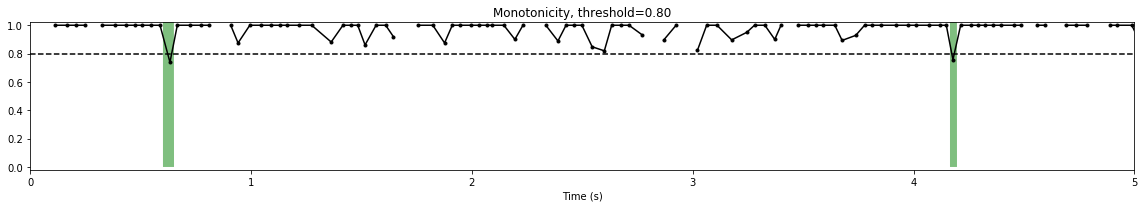

In [15]:
#%% confirm appropriateness of burst detection parameters
region = 'frontal'
sensor = 'MZF01-4408'
signal_df = df_cycles[df_cycles['sensor']==sensor]

if region == 'frontal':
    region = 0
    sensor = frontal.index(sensor)
else:
    region = 1
    sensor = occipital.index(sensor)
    
from bycycle.burst import plot_burst_detect_params
plot_burst_detect_params(signals[region][sensor], Fs, signal_df,
                         burst_kwargs, tlims=(0, 5), figsize=(16, 3), plot_only_result=True)

plot_burst_detect_params(signals[region][sensor], Fs, signal_df,
                         burst_kwargs, tlims=(0, 5), figsize=(16, 3))

Comparison of frontal sensors and occipital sensors:

    region      sensor    volt_amp     period  time_rdsym  time_ptsym
0  frontal  MLF11-4408  222.394368  27.968641    0.497348    0.502892
1  frontal  MLF12-4408  220.661264  26.657382    0.500253    0.506001
2  frontal  MLF13-4408  218.247653  26.189427    0.501001    0.501918
3  frontal  MLF14-4408  223.608993  26.560345    0.498371    0.494776
4  frontal  MLF21-4408  219.415385  27.096000    0.486720    0.508909


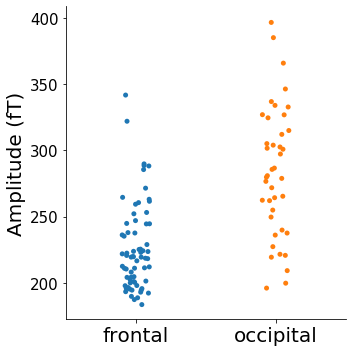

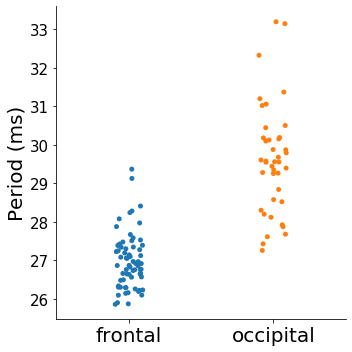

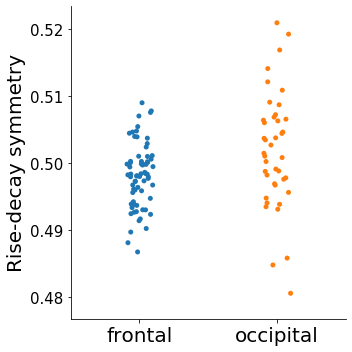

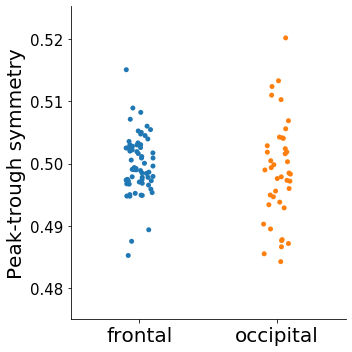

Amplitude (fT)       difference between groups, U= 457, p=0.00000
Period (ms)          difference between groups, U=  88, p=0.00000
Rise-decay symmetry  difference between groups, U= 965, p=0.00275
Peak-trough symmetry difference between groups, U= 1241, p=0.14243


In [16]:
# Only consider cycles that were identified to be in bursting regimes
df_cycles_burst = df_cycles[df_cycles['is_burst']]

# Compute average features across subjects in a recording
features_keep = ['volt_amp', 'period', 'time_rdsym', 'time_ptsym']
df_sensor = df_cycles_burst.groupby(['region','sensor']).mean()[features_keep].reset_index()

df_sensor['volt_amp']=df_sensor['volt_amp']*10**15
print(df_sensor.head())

feature_names = {'volt_amp': 'Amplitude (fT)',
                 'period': 'Period (ms)',
                 'time_rdsym': 'Rise-decay symmetry',
                 'time_ptsym': 'Peak-trough symmetry'}
for feat, feat_name in feature_names.items():
    g = sns.catplot(x='region', y=feat, data=df_sensor)
    plt.xlabel('')
    plt.xticks(size=20)
    plt.ylabel(feat_name, size=20)
    plt.yticks(size=15)
    plt.tight_layout()
    plt.show()
    
for feat, feat_name in feature_names.items():
    x_frontal = df_sensor[df_sensor['region']=='frontal'][feat]
    x_occipital = df_sensor[df_sensor['region']=='occipital'][feat]
    U, p = stats.mannwhitneyu(x_frontal, x_occipital)
    print('{:20s} difference between groups, U= {:3.0f}, p={:.5f}'.format(feat_name, U, p))